Resources used for entire project:

scikit-learn.org


I used these sources for my information on how to preprocess:

https://medium.com/%40devangchavan0204/complete-guide-to-text-preprocessing-in-nlp-b4092c104d3e
https://www.einfochips.com/blog/nlp-text-preprocessing/
https://www.analyticsvidhya.com/blog/2022/05/nlp-preprocessing-steps-in-easy-way/
https://arxiv.org/abs/1806.06407
https://link.springer.com/article/10.1007/s13278-025-01416-z
https://medium.com/analytics-vidhya/text-analysis-of-amazon-customer-reviews-b4fcf0663216
https://www.kaggle.com/code/benroshan/sentiment-analysis-amazon-reviews
https://medium.com/thedeephub/nlp-text-preprocessing-part-1-dfc7d3ee0977
https://www.youtube.com/watch?v=6A2w-KYG4Ko&ab_channel=SatyajitPattnaik

From these sources I determined my best bets for preprocessing would be
Removing white noise
I began my preprocessing pipeline with a normalization phase that systematically stripped away extraneous noise and brought all text into a uniform shape. First, I converted every review to lowercase and removed all instances of HTML tags or embedded URLs using regular-expression substitutions. Next, I enforced a whitelist of characters—namely lowercase letters, digits, and sentence-final punctuation—so that stray symbols, emoticons, or non-ASCII characters were collapsed into spaces. Finally, I merged runs of whitespace and trimmed leading and trailing gaps.
Changing contractions to the same feature
I embedded within this normalization a targeted contraction-expansion step. I rewrote common English contractions such as "can't" or "won't" to their full forms ("cannot," "will not"), and likewise expanded shorter clitics like "'re," "'ve," or "n't." This aligns the text more closely with many lexicons and pre-trained embeddings that assume full-form inputs.
Negation Marking
Once I had cleaned and expanded the text, I passed it through a negation-marking routine. Here, every time a cue like "not," "never," or "no" appeared, I suffixed it with "_NEG," and made this negation flag persist onto each subsequent token until the next sentence punctuation.
Removing Stopwords
Finally, I pruned out stopwords—high-frequency, low-information function words such as "the," "and," or "is." I removed any token of length one or drawn from my predefined stoplist, shrinking the feature set to primarily content-bearing words. By filtering out these frequent but semantically weak tokens, my model could focus its parameters on discriminative adjectives.


In [9]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import (accuracy_score,confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
HTML_PATTERN = re.compile(r"<.*?>")
ALLOWED_CHARS = re.compile(r"[^a-z0-9\.\!\?\'\s]")
CONTRACTIONS = {"can't":"cannot","won't":"will not","n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'ve":" have","'m":" am"}
NEG_CUES = {"not","never","no","n't","cannot"}
STOPWORDS = {"the","and","a","an","of","in","on","at","to","is","it","this","that","i","you","he","she","they","we","was","were","be","been","am","are","but","if","or","as","with","for","not","no","so","too","very"}

def expand_contractions(t):
    for p,r in CONTRACTIONS.items():
        t = re.sub(p,r,t)
    return t

def basic_clean(t):
    t = expand_contractions(t.lower())
    t = HTML_PATTERN.sub(" ",t)
    t = URL_PATTERN.sub(" ",t)
    t = ALLOWED_CHARS.sub(" ",t)
    return re.sub(r"\s+"," ",t).strip()

def clean_series(s):
    return s.astype(str).fillna("").map(basic_clean)

def mark_negations(s):
    out = []
    for txt in s:
        neg = False
        buf = []
        for tok in txt.split():
            if tok in NEG_CUES:
                buf.append(f"{tok}_NEG")
                neg = True
            elif neg and re.fullmatch(r"[a-z0-9']+",tok):
                buf.append(f"{tok}_NEG")
            else:
                buf.append(tok)
                if re.search(r"[\.\!\?]$",tok):
                    neg = False
        out.append(" ".join(buf))
    return pd.Series(out,index=s.index)

def remove_stopwords(s):
    return s.map(lambda t:" ".join(w for w in t.split() if len(w)>1 and w not in STOPWORDS))

def show_cv_table(res, cols):
    df = pd.DataFrame(res)
    param_cols = [f"param_{c}" for c in cols]
    tbl = df[param_cols + ["mean_test_score", "std_test_score"]]
    tbl = tbl.rename(columns=dict(zip(param_cols, cols)))
    display(tbl.sort_values("mean_test_score", ascending=False))


def evaluate_model(y_true,y_pred,y_prob,name):
    print(name)
    print("accuracy",accuracy_score(y_true,y_pred))
    print("f1_macro",f1_score(y_true,y_pred,average="macro"))
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(4,4)); plt.imshow(cm,cmap="Blues"); plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]),ha="center",va="center",color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.show()
    fpr,tpr,_ = roc_curve(y_true,y_prob)
    plt.figure(); plt.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def run_cv(build_fn,X,y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipes,grids = build_fn()
    best_models = {}
    scores = {}
    for name,pipe in pipes.items():
        gs = GridSearchCV(pipe,grids[name],cv=cv,scoring="f1_macro",n_jobs=-1,verbose=1)
        gs.fit(X,y)
        show_cv_table(gs.cv_results_,list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        if name == "SVM":
            scr = cross_val_predict(best_models[name],X,y,cv=cv,method="decision_function")
            preds = (scr >= 0).astype(int)
            probs = expit(scr)
        else:
            preds = cross_val_predict(best_models[name],X,y,cv=cv,method="predict")
            probs = cross_val_predict(best_models[name],X,y,cv=cv,method="predict_proba")[:,1]
        evaluate_model(y,preds,probs,name)
        scores[name] = f1_score(y,preds,average="macro")
    best_name = max(scores,key=scores.get)
    return best_models[best_name]

From here, I added different types of pipelines and vectorizing strategies for my models. In this first set, the first pipeline uses a binary bag‐of‐n-grams approach: a CountVectorizer extracts up to 10 000 unigrams and bigrams that appear in at least three but no more than 70 percent of documents, and records only their presence or absence. These binary features feed into a Multinomial Naïve Bayes model, whose simplicity and closed‐form parameter estimates make it extremely fast and robust to sparse inputs. The second pipeline upgrades raw counts to TF–IDF weights—using the same vocabulary constraints and sublinear term‐frequency scaling—then trains a Logistic Regression classifier with balanced class weights. This combination leverages TF–IDF’s ability to down‐weight ubiquitous terms and highlight discriminative words, while logistic regression offers calibrated probability outputs and a clear geometric interpretation of the decision boundary. The third pipeline also employs TF–IDF features but relaxes the document‐frequency ceiling slightly to admit more frequent tokens, and pairs these with a Linear Support Vector Machine. The SVM maximizes the margin between positive and negative classes in the high‐dimensional n-gram space, and its extended iteration budget ensures convergence on the large, sparse feature set.
Sources:
https://cdn.aaai.org/Workshops/1998/WS-98-05/WS98-05-007.pdf

https://ecommons.cornell.edu/server/api/core/bitstreams/fc18789c-6a03-48e6-8226-7dba0ce94e32/content

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

https://www.geeksforgeeks.org/bernoulli-naive-bayes/

https://arxiv.org/html/2410.08728v1

https://www.ibm.com/reference/python/countvectorizer

https://link.springer.com/article/10.1007/s11042-022-12538-3

reddit.com



Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
1,1.0,0.778964,0.006679
0,0.1,0.777685,0.007173


NB
accuracy 0.8481442133040885
f1_macro 0.778916147185104


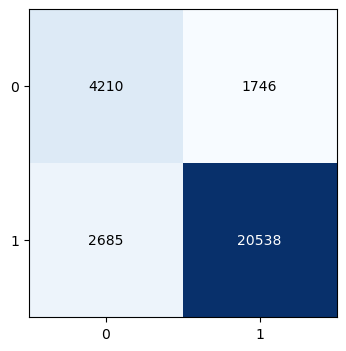

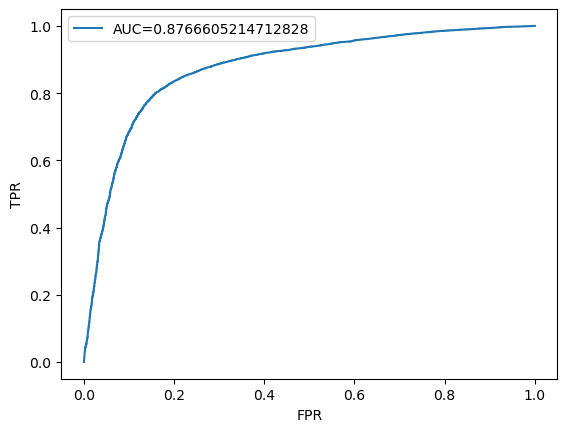

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
1,1.0,0.792097,0.006849
0,0.5,0.788328,0.006222


LR
accuracy 0.8480071284142705
f1_macro 0.7920728830703705


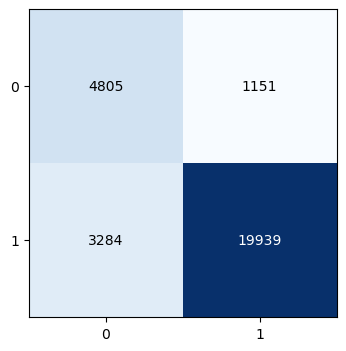

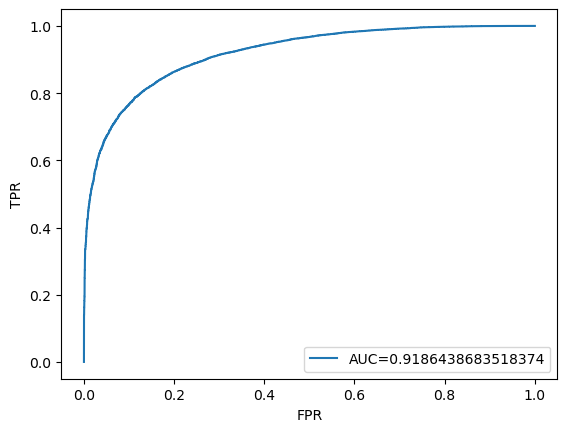

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.783762,0.008877
1,1.0,0.776620,0.005205


SVM
accuracy 0.8461564824017273
f1_macro 0.7837386644316803


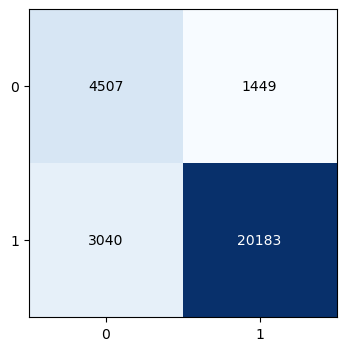

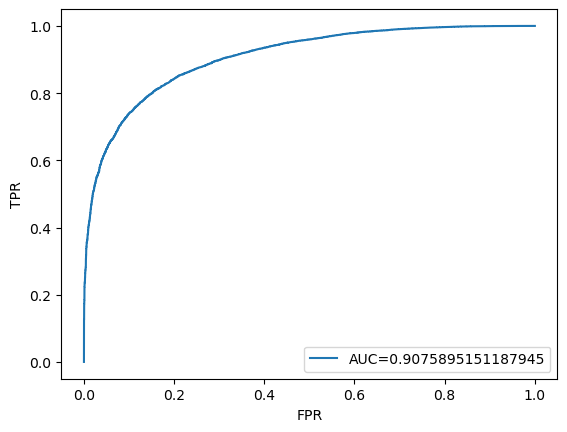

In [10]:
def load_data_fp():
    tr = pd.read_csv("train1.csv").drop_duplicates()
    te = pd.read_csv("test1.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("")+" "+tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("")+" "+te["summary"].fillna("")
    tr = tr[tr["combined"].str.len()>10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = (tr["overall"]>1).astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def build_pipelines_fp():
    cnt = CountVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,binary=True)
    tfd = TfidfVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,sublinear_tf=True)
    pipe_nb = Pipeline([("vect",cnt),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("vect",tfd),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=300))])
    pipe_svm = Pipeline([("vect",TfidfVectorizer(stop_words="english",lowercase=True,max_df=0.8,min_df=3,sublinear_tf=True,ngram_range=(1,2),max_features=10000)),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,1]},"LR":{"clf__C":[0.5,1]},"SVM":{"clf__C":[0.5,1]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_fp()
    best_model = run_cv(build_pipelines_fp,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("text1_output1.csv",index=False)


I picked SVM, NB, and LR. The best hyperparameters are chosen automatically through a two‐stage cross‐validation process. First, for each of the three pipelines (Naïve Bayes, Logistic Regression, and Linear SVM), a GridSearchCV object evaluates every candidate setting (α for NB; C for LR/SVM) across five stratified folds, using the macro-averaged F1 score as its metric. GridSearchCV then records the mean F1 for each hyperparameter value and exposes best_estimator_, which corresponds to the setting with the highest average F1. In the second stage, the script uses each pipeline’s best_estimator_ to generate out-of-fold predictions on the full training set and computes their macro-F1 scores. Finally, it selects the pipeline whose tuned model achieves the highest cross-validated F1


This approach works; however, I wanted to try other approaches in my pipeline and vectorizing strategies to possibly increase my F1 score:

For my second strategy, I rewrote the data‐loading stage to treat each field on its own rather than lumping everything into a single “combined” string. In load_data_mid(), I apply my cleaning and negation‐marking functions separately to reviewText and to summary, preserving the distinct linguistic patterns of long-form reviews versus short synopses. At the same time, I decided to bring back structured metadata—so I convert the product category to a string, one-hot–encode the boolean verified flag, and log-transform the numeric vote count. These extra features inject signals about product domain, reviewer credibility, and community endorsement that pure n-grams can miss, while the binary label and ID handling remain exactly as before.
In preprocessor_mid() I replaced my old ad hoc vectorizers with a single ColumnTransformer that assembles every feature into one sparse matrix. I allocate a large (60 000-feature) TF–IDF on 1–2-grams for the cleaned reviews, a smaller (15 000-feature) unigram TF–IDF for summaries, and a character-ngram TF–IDF (3–5 chars) for categories. Meanwhile, verified flows through a OneHotEncoder and vote through a FunctionTransformer(np.log1p).Finally, in build_pipelines_mid() I plug this ColumnTransformer into each classifier pipeline and expand my hyperparameter searches to match the larger feature space: smoothing α ∈ {0.1, 0.5, 1.0} for MultinomialNB, and regularization C ∈ {0.5, 1.0, 2.0} for both LR and SVM. This broader grid, evaluated under five-fold stratified cross-validation optimizing macro-F1, lets me find the right balance of bias and variance when combining text and metadata.

Sources:

https://dataknowsall.com/blog/hyperparameter.html

https://medium.com/%40figueiredor.pedro/how-to-customize-hyperparameter-optimization-5ab1a55db1a

https://www.datacamp.com/tutorial/one-hot-encoding-python-tutorial

https://medium.com/%40paghadalsneh/feature-engineering-with-function-transformer-3c1f6c8f000e

https://www.analyticsvidhya.com/blog/2021/05/understanding-column-transformer-and-machine-learning-pipelines

https://www.geeksforgeeks.org/ml-one-hot-encoding

https://www.geeksforgeeks.org/using-columntransformer-in-scikit-learn-for-data-preprocessing

https://medium.com/%40pacosun/stratified-k-fold-cross-validation-when-balance-matters-c28b9a7cb9bc


Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.777382,0.008909
1,0.5,0.703629,0.011173
2,1.0,0.612953,0.009080


NB
accuracy 0.8691973003528727
f1_macro 0.7774566877295852


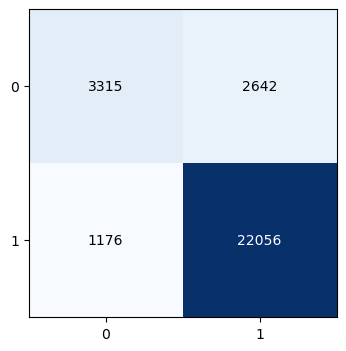

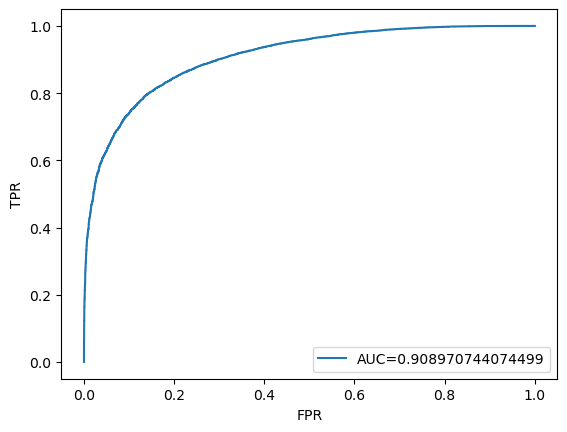

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
2,2.0,0.795404,0.004923
1,1.0,0.793057,0.005954
0,0.5,0.789860,0.003460


LR
accuracy 0.8575490767069787
f1_macro 0.7954257580339879


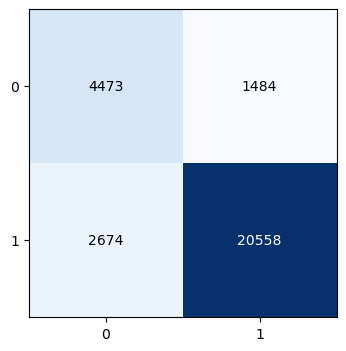

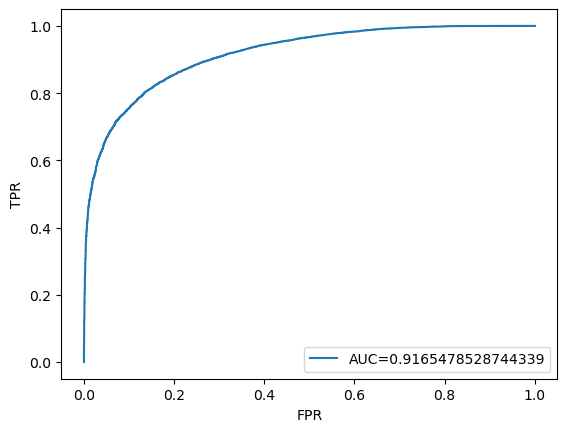

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.788467,0.006983
1,1.0,0.784089,0.008604
2,2.0,0.777536,0.009682


SVM
accuracy 0.8571722224125526
f1_macro 0.7885047322508395


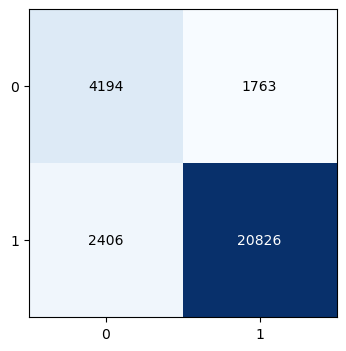

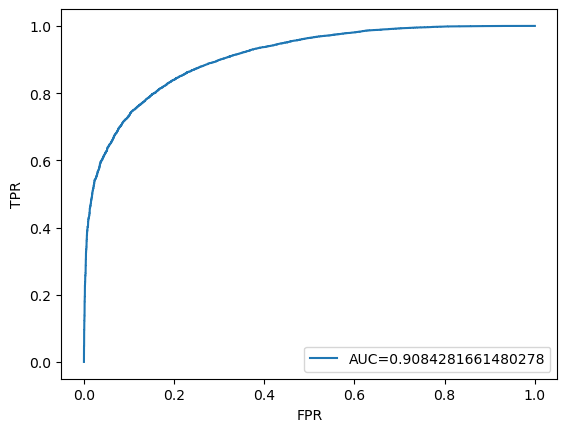

In [11]:
def load_data_mid():
    tr = pd.read_csv("train1.csv").drop_duplicates()
    te = pd.read_csv("test1.csv").drop_duplicates()
    for df in (tr,te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
        df["verified"] = df["verified"].fillna(False).astype(int)
        df["vote"] = pd.to_numeric(df["vote"].astype(str).str.replace(",",""),errors="coerce").fillna(0.0)
    y = (tr["overall"]>1).astype(int).values
    ids = te["id"].tolist()
    return tr.drop(columns=["overall"]), te, y, ids

def preprocessor_mid():
    tfidf_review = TfidfVectorizer(max_features=60000,ngram_range=(1,2),stop_words="english",min_df=3,sublinear_tf=True)
    tfidf_summary = TfidfVectorizer(max_features=15000,ngram_range=(1,1),stop_words="english",min_df=2,sublinear_tf=True)
    tfidf_category = TfidfVectorizer(analyzer="char",ngram_range=(3,5),min_df=1)
    return ColumnTransformer([
        ("review",tfidf_review,"reviewText"),
        ("summary",tfidf_summary,"summary"),
        ("category",tfidf_category,"category"),
        ("verified",OneHotEncoder(handle_unknown="ignore"),["verified"]),
        ("vote",FunctionTransformer(func=np.log1p,validate=False,feature_names_out="one-to-one"),["vote"])
    ],remainder="drop",sparse_threshold=0.3)

def build_pipelines_mid():
    feat = preprocessor_mid()
    pipe_nb = Pipeline([("feat",feat),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("feat",feat),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=2000))])
    pipe_svm = Pipeline([("feat",feat),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,0.5,1.0]},"LR":{"clf__C":[0.5,1.0,2.0]},"SVM":{"clf__C":[0.5,1.0,2.0]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_mid()
    best_model = run_cv(build_pipelines_mid,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("test1_output2.csv",index=False)

Finally, in my third approach, in load_data_last(), I still apply the same cleaning and negation marking to reviewText and summary and normalize the category column, but I no longer load or transform the verified flag or the vote counts. I return only three columns—reviewText, summary, and category—rather than the full DataFrame with extra numeric and boolean fields. Consequently, my ColumnTransformer in vectoriser_last() only contains three transformers: a large TF–IDF (1–2 grams) for reviews, a smaller unigram TF–IDF for summaries, and a character NGram TF–IDF for categories. In contrast, the mid-pipeline’s preprocessor_mid() also encoded verified via one-hot encoding and vote via a log1p FunctionTransformer. By removing those two transformers, the last approach collapses back to a pure text-based feature space—much like the very first model—but still preserves the per-column TF–IDF granularity introduced in the mid version. The downstream classifiers and hyperparameter grids remain identical, but the feature matrix is now simpler and exclusively textual.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.772344,0.012756
1,0.5,0.697770,0.012079
2,1.0,0.621439,0.009843


NB
accuracy 0.8673815478433656
f1_macro 0.7724714848213485


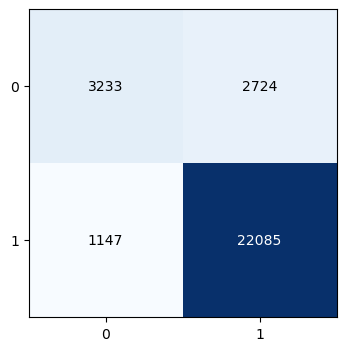

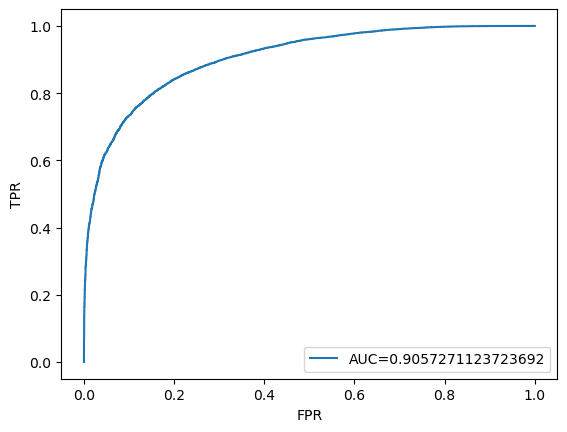

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
2,2.0,0.793136,0.006843
1,1.0,0.790987,0.005742
0,0.5,0.787988,0.006582


LR
accuracy 0.8559388810853403
f1_macro 0.7931694188416456


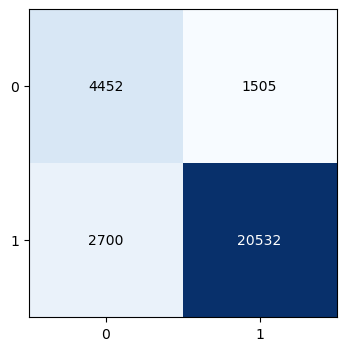

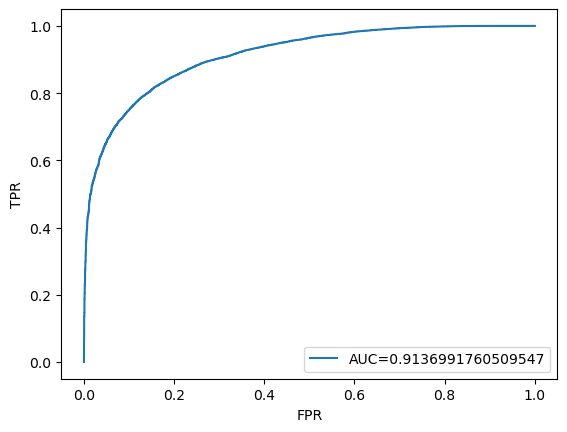

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.785704,0.008124
1,1.0,0.779319,0.008604
2,2.0,0.773948,0.008930


SVM
accuracy 0.8552879509404228
f1_macro 0.7857517127443863


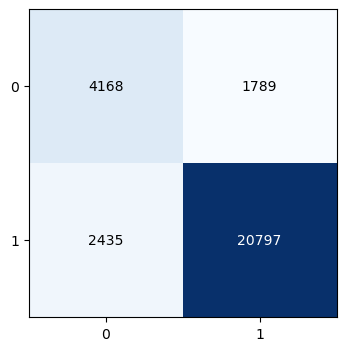

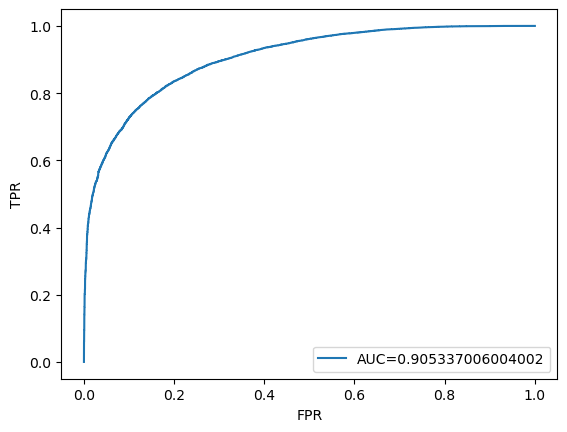

In [12]:
def load_data_last():
    tr = pd.read_csv("train1.csv").drop_duplicates()
    te = pd.read_csv("test1.csv").drop_duplicates()
    for df in (tr, te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
    y = (tr["overall"] > 1).astype(int).values
    ids = te["id"].tolist()
    X_tr = tr[["reviewText", "summary", "category"]].copy()
    X_te = te[["reviewText", "summary", "category"]].copy()
    return X_tr, X_te, y, ids

def vectoriser_last():
    return ColumnTransformer(
        transformers=[
            ("review", TfidfVectorizer(max_features=60000, ngram_range=(1, 2), stop_words="english", min_df=3, sublinear_tf=True), "reviewText"),
            ("summary", TfidfVectorizer(max_features=15000, ngram_range=(1, 1), stop_words="english", min_df=2, sublinear_tf=True), "summary"),
            ("category", TfidfVectorizer(analyzer="char", ngram_range=(3, 5), min_df=1), "category"),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )

def build_pipelines_last():
    vec = vectoriser_last()
    pipe_nb = Pipeline([("vec", vec), ("clf", MultinomialNB())])
    pipe_lr = Pipeline([("vec", vec), ("clf", LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000))])
    pipe_svm = Pipeline([("vec", vec), ("clf", LinearSVC(class_weight="balanced", max_iter=3000))])
    grids = {
        "NB": {"clf__alpha": [0.1, 0.5, 1.0]},
        "LR": {"clf__C": [0.5, 1.0, 2.0]},
        "SVM": {"clf__C": [0.5, 1.0, 2.0]}
    }
    return {"NB": pipe_nb, "LR": pipe_lr, "SVM": pipe_svm}, grids

if __name__ == "__main__":
    X_tr, X_te, y, ids = load_data_last()
    best_model = run_cv(build_pipelines_last, X_tr, y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id": ids, "overall": preds}).to_csv("test1_output3.csv", index=False)

-----------------------------------------------------------------------

Sources referenced for multiclass classifier:

https://medium.com/analytics-vidhya/the-best-feature-selection-technique-for-text-classification-23199b4a4f8d

https://pmc.ncbi.nlm.nih.gov/articles/PMC7302864/

https://www.geeksforgeeks.org/tf-idf-for-bigrams-trigrams/

https://www.geeksforgeeks.org/probability-calibration-of-classifiers-in-scikit-learn/

https://medium.com/%40Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48

https://github.com/scikit-learn/scikit-learn/issues/21455


https://datascience.stackexchange.com/questions/96641/what-are-the-advantages-disadvantages-of-using-tfidf-on-n-grams-generated-throug



For my multiclass classifier, I kept the same “vectorize-then-classify” framework from the approach in set 1 of models, but adapted everything for a true multi-class task: I switched Logistic Regression to the multinomial “lbfgs” solver, and for the SVM pipeline I added a SelectKBest(chi2, k=6000) step to prune down to the most informative n-grams and wrapped the classifier in CalibratedClassifierCV so I could produce well-calibrated probabilities for ROC-AUC. I moved from full cross-validation to an 80/20 train/validation split, used label_binarize to generate one-vs-rest ROC curves and compute a macro-AUC, and still optimized macro-F1 via GridSearchCV. This way, I support true multinomial loss, feature selection, probability calibration, and proper multi-class ROC/AUC evaluation.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
1,1.0,0.471443,0.004055
0,0.1,0.468615,0.006197


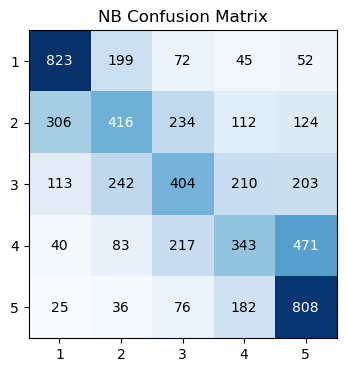

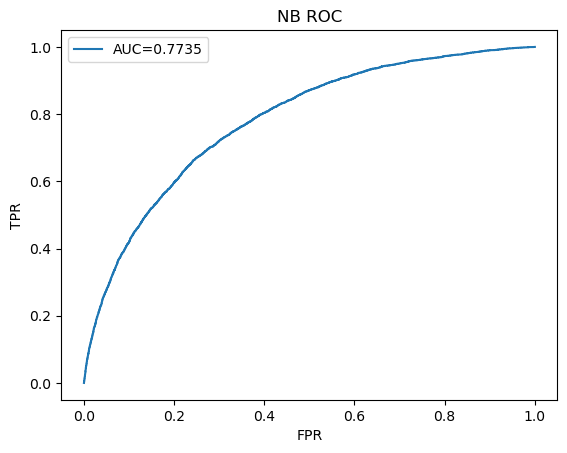

NB accuracy 0.47875257025359835 f1_macro 0.4659449892541689 roc_auc_macro 0.7734589319487013
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.510266,0.003433
1,1.0,0.508884,0.003761


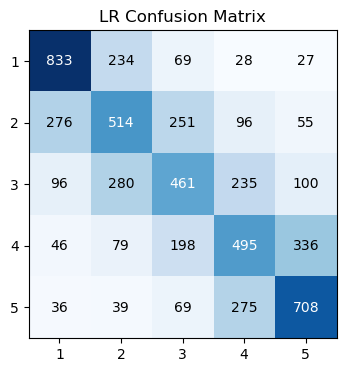

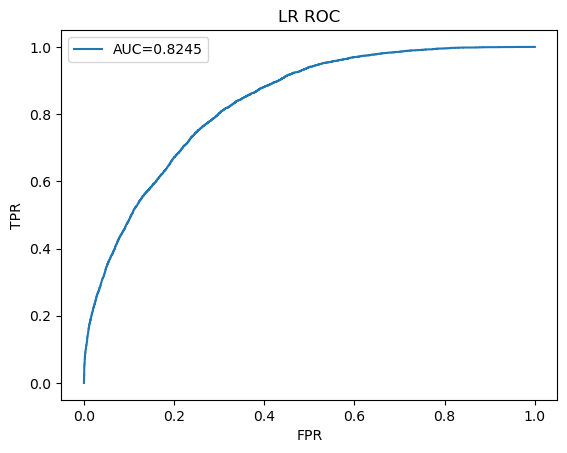

LR accuracy 0.5159355723098012 f1_macro 0.5125497293584536 roc_auc_macro 0.8244805744562976
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,calib__estimator__C,mean_test_score,std_test_score
0,0.5,0.498263,0.005838
1,1.0,0.489525,0.007740


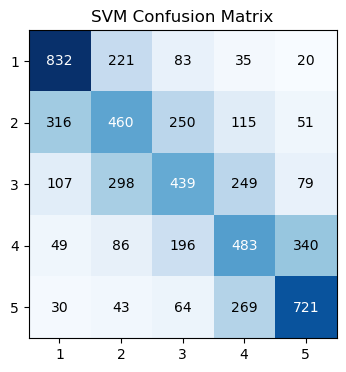

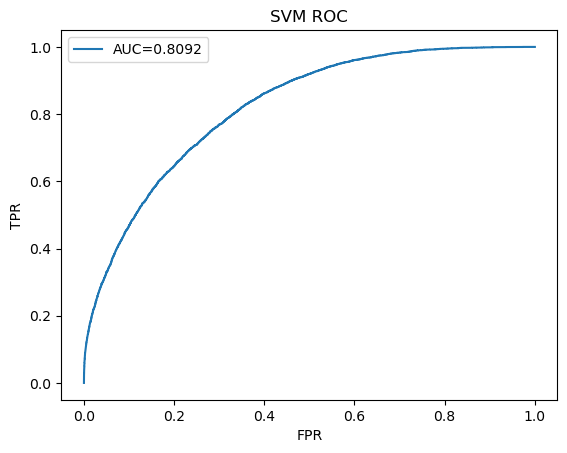

SVM accuracy 0.5029129540781357 f1_macro 0.4986463822639683 roc_auc_macro 0.8092250283870343


In [13]:
import warnings
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize


warnings.filterwarnings("ignore", category=FutureWarning)

def load_data_mc():
    tr = pd.read_csv("train5.csv").drop_duplicates().reset_index(drop=True)
    te = pd.read_csv("test5.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("") + " " + tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("") + " " + te["summary"].fillna("")
    tr = tr[tr["combined"].str.len() > 10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = tr["overall"].astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def vectorisers_mc():
    cnt = CountVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english", min_df=3, max_df=0.7, binary=True)
    tfd = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english", min_df=3, max_df=0.7, sublinear_tf=True)
    tfidf_svm = TfidfVectorizer(stop_words="english", lowercase=True, max_df=0.8, min_df=3, sublinear_tf=True, ngram_range=(1,2), max_features=10000)
    return cnt, tfd, tfidf_svm

def build_pipelines_mc():
    cnt, tfd, tfidf_svm = vectorisers_mc()
    pipe_nb  = Pipeline([("vect", cnt), ("clf", MultinomialNB())])
    pipe_lr  = Pipeline([("vect", tfd), ("clf", LogisticRegression(class_weight="balanced", solver="lbfgs", multi_class="multinomial", max_iter=500))])
    pipe_svm = Pipeline([
        ("tfidf", tfidf_svm),
        ("select", SelectKBest(chi2, k=6000)),
        ("calib", CalibratedClassifierCV(estimator=LinearSVC(class_weight="balanced", max_iter=5000), method="sigmoid", cv=5, n_jobs=-1))
    ])
    grids = {"NB": {"clf__alpha": [0.1, 1.0]}, "LR": {"clf__C": [0.5, 1.0]}, "SVM": {"calib__estimator__C": [0.5, 1.0]}}
    return {"NB": pipe_nb, "LR": pipe_lr, "SVM": pipe_svm}, grids

def evaluate_model_mc(y_true, y_pred, y_score, name):
    acc = accuracy_score(y_true, y_pred); f1 = f1_score(y_true, y_pred, average="macro")
    classes = np.unique(y_true); cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(4,4)); plt.imshow(cm, cmap="Blues"); plt.xticks(range(len(classes)), classes); plt.yticks(range(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.title(f"{name} Confusion Matrix"); plt.show()
    y_bin = label_binarize(y_true, classes=classes); fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    auc_val = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc_val:.4f}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title(f"{name} ROC"); plt.show()
    print(name, "accuracy", acc, "f1_macro", f1, "roc_auc_macro", auc_val); return f1

def run_holdout(build_fn, X, y):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipes, grids = build_fn(); best_models = {}; scores = {}
    for name, pipe in pipes.items():
        gs = GridSearchCV(pipe, grids[name], cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring="f1_macro", n_jobs=-1, verbose=1)
        gs.fit(X_tr, y_tr); show_cv_table(gs.cv_results_, list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        y_pred = best_models[name].predict(X_val); y_proba = best_models[name].predict_proba(X_val)
        scores[name] = evaluate_model_mc(y_val, y_pred, y_proba, name)
    return best_models[max(scores, key=scores.get)]

if __name__ == "__main__":
    X_tr, X_te, y, ids = load_data_mc()
    best_model = run_holdout(build_pipelines_mc, X_tr, y)
    best_model.fit(X_tr, y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id": ids, "overall": preds}).to_csv("text1_output4_mc.csv", index=False)



However, my mutliclass classifier was not performing well enough, and I wanted to upgrade the performance drastically. Thus, I changed the unified Pipeline/ColumnTransformer pattern and instead hand‐craft each model’s feature matrix outside of a scikit-learn pipeline. I first concatenate reviewText and summary into one “combined” string and apply my cleaning/negation/stopword steps to that. Then, for Naïve Bayes I fit a binary CountVectorizer on the preprocessed texts; for Logistic Regression I separately fit a word-level TF-IDF and a char-level TF-IDF and horizontally stack them into one sparse matrix; and for SVM I wrap a TF-IDF→SelectKBest→CalibratedClassifierCV sequence in a Pipeline that vectorizes on the fly. Hyperparameter tuning still uses GridSearchCV over α or C, but each classifier now draws from its own bespoke feature set rather than a shared transformer. I also replaced the cross-validation wrapper with explicit cross_val_predict calls and a custom evaluate_metrics routine that prints classification reports, plots confusion matrices, and draws one-vs-rest ROC curves per class. Finally, I manually pick the best model by comparing its macro-F1 in a results dictionary and apply the corresponding feature transforms to the test set, instead of using the earlier run_cv abstraction.


Fitting 5 folds for each of 2 candidates, totalling 10 fits

NB  ACC:0.4877  F1:0.4738  AUC:0.7804
              precision    recall  f1-score   support

           1     0.6309    0.6901    0.6592      5956
           2     0.4357    0.3524    0.3896      5959
           3     0.4221    0.3534    0.3847      5860
           4     0.3910    0.2995    0.3392      5767
           5     0.4954    0.7490    0.5964      5637

    accuracy                         0.4877     29179
   macro avg     0.4750    0.4889    0.4738     29179
weighted avg     0.4755    0.4877    0.4736     29179



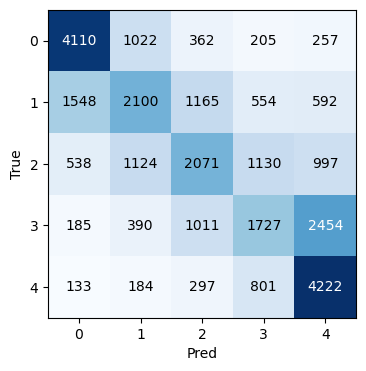

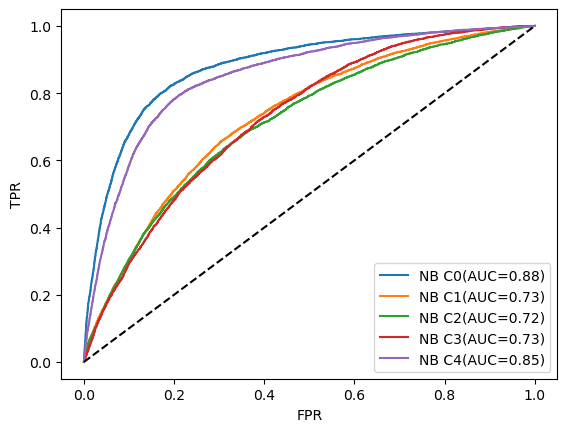

Fitting 5 folds for each of 2 candidates, totalling 10 fits

LR  ACC:0.5946  F1:0.5936  AUC:0.8785
              precision    recall  f1-score   support

           1     0.6484    0.7001    0.6733      5956
           2     0.5139    0.4887    0.5009      5959
           3     0.5367    0.5000    0.5177      5860
           4     0.5584    0.5665    0.5624      5767
           5     0.7054    0.7222    0.7137      5637

    accuracy                         0.5946     29179
   macro avg     0.5926    0.5955    0.5936     29179
weighted avg     0.5917    0.5946    0.5927     29179



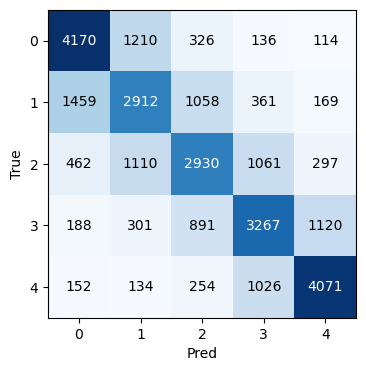

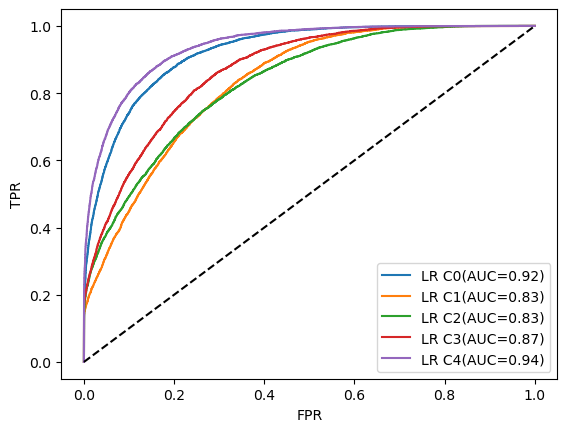

Fitting 5 folds for each of 2 candidates, totalling 10 fits

SVM  ACC:0.5082  F1:0.5036  AUC:0.8135
              precision    recall  f1-score   support

           1     0.6285    0.6986    0.6617      5956
           2     0.4266    0.3934    0.4093      5959
           3     0.4259    0.3706    0.3964      5860
           4     0.4302    0.4300    0.4301      5767
           5     0.5923    0.6512    0.6204      5637

    accuracy                         0.5082     29179
   macro avg     0.5007    0.5088    0.5036     29179
weighted avg     0.5004    0.5082    0.5031     29179



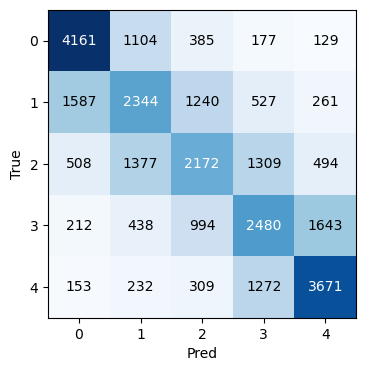

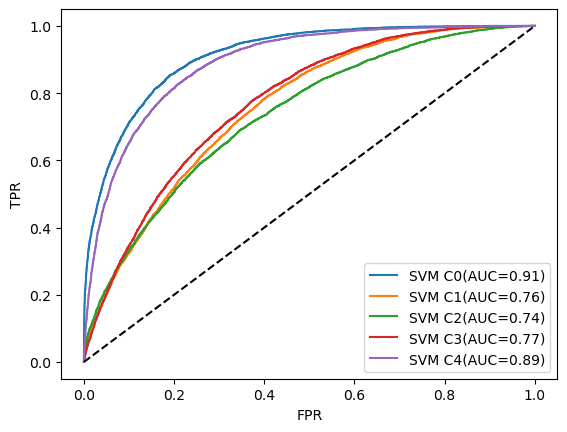

Best:LR F1=0.5936


In [14]:


train = pd.read_csv("train5.csv").drop_duplicates().reset_index(drop=True)
test = pd.read_csv("test5.csv").reset_index(drop=True)

for df in (train, test):
    df["reviewText"] = df["reviewText"].fillna("").astype(str)
    df["summary"] = df["summary"].fillna("").astype(str)
    df["combined"] = df["reviewText"] + " " + df["summary"]

train = train[train["combined"].str.len() > 10].reset_index(drop=True)

def preprocess_text(s):
    return remove_stopwords(mark_negations(clean_series(s))).tolist()

train_texts = preprocess_text(train["combined"])
test_texts = preprocess_text(test["combined"])
y_train = train["overall"].astype(int).values
test_ids = test["id"].tolist()

count_vect = CountVectorizer(
    max_features=10000, ngram_range=(1,2),
    stop_words="english", min_df=3, max_df=0.7, binary=True
)
X_count = count_vect.fit_transform(train_texts)
Xc_test = count_vect.transform(test_texts)

word_tfidf = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),
    stop_words="english", min_df=3, max_df=0.7,
    max_features=20000, sublinear_tf=True
)
char_tfidf = TfidfVectorizer(
    analyzer="char", ngram_range=(3,5),
    min_df=3, max_df=0.7, max_features=30000, sublinear_tf=True
)
X_train = sp.hstack([
    word_tfidf.fit_transform(train_texts),
    char_tfidf.fit_transform(train_texts)
]).tocsr()
X_test = sp.hstack([
    word_tfidf.transform(test_texts),
    char_tfidf.transform(test_texts)
]).tocsr()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

def evaluate_metrics(name, y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    roc = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    print(f"\n{name}  ACC:{acc:.4f}  F1:{f1m:.4f}  AUC:{roc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j],
                     ha="center", va="center",
                     color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.xlabel("Pred"); plt.ylabel("True"); plt.show()
    yb = pd.get_dummies(y_true).values
    plt.figure()
    for i in range(yb.shape[1]):
        fpr, tpr, _ = roc_curve(yb[:,i], y_score[:,i])
        plt.plot(fpr, tpr, label=f"{name} C{i}(AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1], [0,1], "k--"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()
    return {"accuracy": acc, "f1_macro": f1m, "roc_auc": roc}

nb = MultinomialNB()
g_nb = GridSearchCV(nb, {"alpha":[0.1,1.0]}, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
g_nb.fit(X_count, y_train)
b_nb = g_nb.best_estimator_
p_nb = cross_val_predict(b_nb, X_count, y_train, cv=cv)
pr_nb = cross_val_predict(b_nb, X_count, y_train, cv=cv, method="predict_proba")
results["NB"] = evaluate_metrics("NB", y_train, p_nb, pr_nb)

lr = LogisticRegression(
    multi_class="multinomial", solver="lbfgs",
    class_weight="balanced", max_iter=500
)
g_lr = GridSearchCV(lr, {"C":[0.5,1.0]}, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
g_lr.fit(X_train, y_train)
b_lr = g_lr.best_estimator_
p_lr = cross_val_predict(b_lr, X_train, y_train, cv=cv)
pr_lr = cross_val_predict(b_lr, X_train, y_train, cv=cv, method="predict_proba")
results["LR"] = evaluate_metrics("LR", y_train, p_lr, pr_lr)

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english", lowercase=True,
        max_df=0.8, min_df=3, sublinear_tf=True,
        ngram_range=(1,2), max_features=10000
    )),
    ("select", SelectKBest(chi2, k=6000)),
    ("calib", CalibratedClassifierCV(
        estimator=LinearSVC(class_weight="balanced", max_iter=5000),
        method="sigmoid", cv=5, n_jobs=-1
    ))
])
g_svm = GridSearchCV(svm_pipe, {"calib__estimator__C":[0.5,1.0]}, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
g_svm.fit(train_texts, y_train)
b_svm = g_svm.best_estimator_
p_svm = cross_val_predict(b_svm, train_texts, y_train, cv=cv, method="predict")
pr_svm = cross_val_predict(b_svm, train_texts, y_train, cv=cv, method="predict_proba")
results["SVM"] = evaluate_metrics("SVM", y_train, p_svm, pr_svm)

best = max(results, key=lambda k: results[k]["f1_macro"])
print(f"Best:{best} F1={results[best]['f1_macro']:.4f}")

if best == "NB":
    final = b_nb.predict(Xc_test)
elif best == "LR":
    final = b_lr.predict(X_test)
else:
    final = b_svm.predict(test_texts)

pd.DataFrame({"id": test_ids, "overall": final}).to_csv("submission_multiclass_full_metrics.csv", index=False)


This gave me F-1 Macro scores close to 0.60, which is what I wanted and was closer to the scores recieved by the higher scorers on kaggle.

---------------------------------------------------------------

My K-means clustering classifier concatenates each review’s text and summary, applies cleaning and negation marking, then vectorizes the result with TF–IDF (optionally followed by SVD to 120 dimensions). It uses KMeans—initialized 20 times—to partition the data into as many clusters as there are product categories, and evaluates cluster quality via cosine-based silhouette score and supervised Adjusted Rand Index. Finally, it prints a contingency table showing how predicted clusters align with true categories.

In [15]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

TEXT_COLS = ["reviewText", "summary"]
LABEL_COL = "category"
N_COMPONENTS = 120
N_INIT = 20
RANDOM_STATE = 42
MIN_DF = 3
MAX_FEATURES = 65000
NGRAM_RANGE = (1, 2)
BASELINE_SIL = 0.050

train_df = shuffle(pd.read_csv("train5.csv"), random_state=RANDOM_STATE).reset_index(drop=True)
test_df = shuffle(pd.read_csv("test5.csv"), random_state=RANDOM_STATE).reset_index(drop=True)

train_combined = train_df[TEXT_COLS].fillna("").agg(" ".join, axis=1)
test_combined = test_df[TEXT_COLS].fillna("").agg(" ".join, axis=1)

train_texts = remove_stopwords(mark_negations(clean_series(train_combined)))
test_texts = remove_stopwords(mark_negations(clean_series(test_combined)))

steps = [
    ("tfidf", TfidfVectorizer(
        lowercase=False,
        stop_words="english",
        min_df=MIN_DF,
        max_features=MAX_FEATURES,
        ngram_range=NGRAM_RANGE,
        sublinear_tf=True
    ))
]

if N_COMPONENTS:
    steps.append(("svd", TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)))

vector_pipe = Pipeline(steps)

X_train = vector_pipe.fit_transform(train_texts)
X_test = vector_pipe.transform(test_texts)

le = LabelEncoder()
y_test = le.fit_transform(test_df[LABEL_COL])

n_clusters = len(le.classes_)
print(f"Clustering into {n_clusters} clusters.")

km = KMeans(n_clusters=n_clusters, n_init=N_INIT, max_iter=300, random_state=RANDOM_STATE, verbose=0)

pred_clusters = km.fit_predict(X_test)

sil = silhouette_score(X_test, pred_clusters, metric="cosine")
ari = adjusted_rand_score(y_test, pred_clusters)

print("Results:")
print(f"Silhouette score (cosine): {sil:.4f}")
print(f"Adjusted Rand Index:       {ari:.4f}")
print("Passed the baseline silhouette threshold" if sil >= BASELINE_SIL else "Below the baseline silhouette threshold.")

if __name__ == "__main__":
    crosstab = pd.crosstab(pred_clusters, y_test, rownames=["Cluster"], colnames=["True Label"])
    print("Cluster ↔ True-label contingency:")
    print(crosstab.head(10))


Clustering into 6 clusters.
Results:
Silhouette score (cosine): 0.0576
Adjusted Rand Index:       0.0088
Passed the baseline silhouette threshold!
Cluster ↔ True-label contingency:
True Label    0    1    2    3    4    5
Cluster                                 
0            46  115  113  103   98  110
1             2    5    6    2    2    3
2             3    6   10   10    2    7
3           309  350  318  401  360  374
4            15   88   73   50   44   43
5           375  186  230  184  244  213


---------------------------------------------------------------------------------------------------

From here on, these are the reports for classifiers 2, 3, 4, 5:


For classifiers thresholds 2,3,4,5 I picked the two best performing classifying approaches from the 3 strategies, and created two output files per 3 models.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
1,1.0,0.797064,0.004473
0,0.1,0.796702,0.004165


NB
accuracy 0.8047225744542308
f1_macro 0.7970793144009887


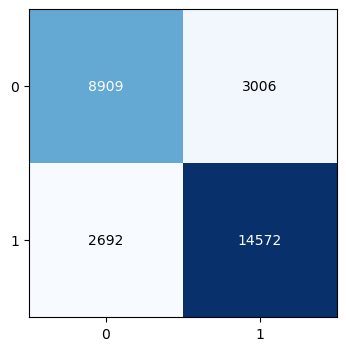

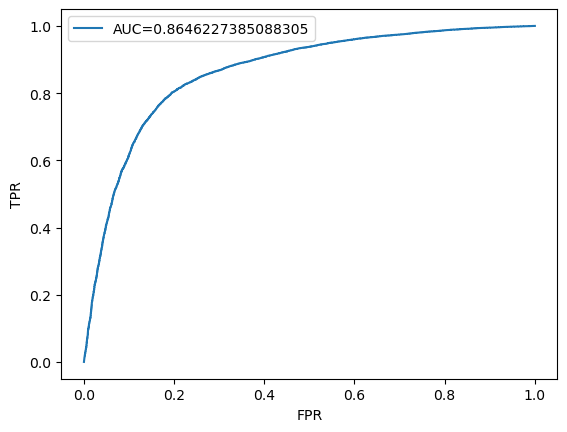

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
1,1.0,0.823785,0.00715
0,0.5,0.821821,0.00642


LR
accuracy 0.8280612769457486
f1_macro 0.8237840401467148


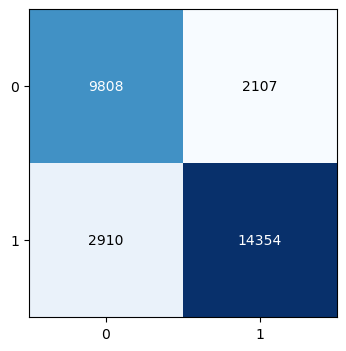

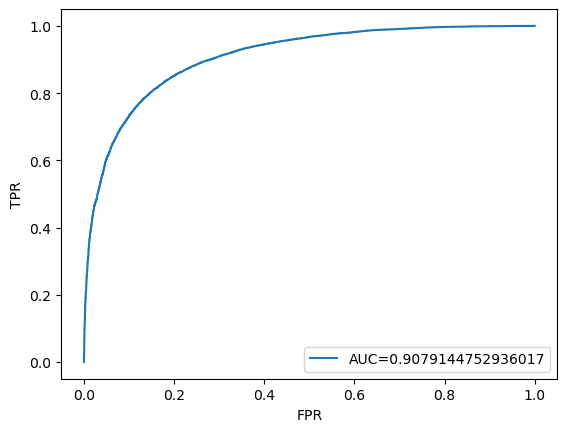

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.813573,0.008384
1,1.0,0.804440,0.008680


SVM
accuracy 0.8184996058809417
f1_macro 0.8135695892779296


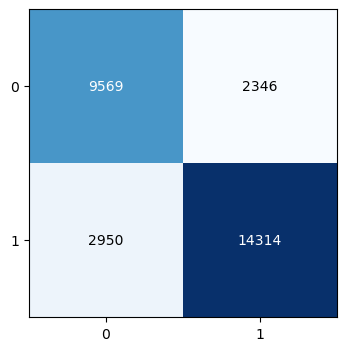

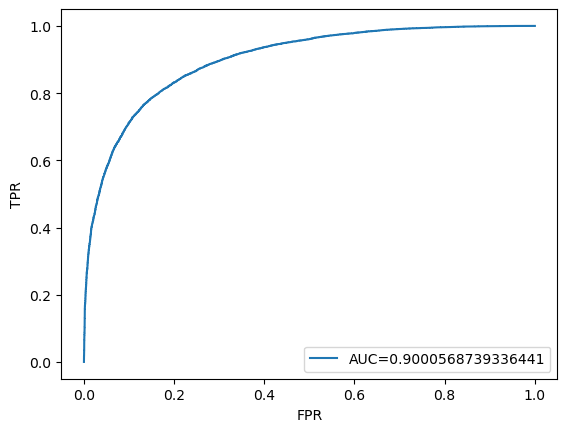

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.803238,0.002338
1,0.5,0.799018,0.004139
2,1.0,0.784071,0.005250


NB
accuracy 0.8122923018945493
f1_macro 0.8032485066341686


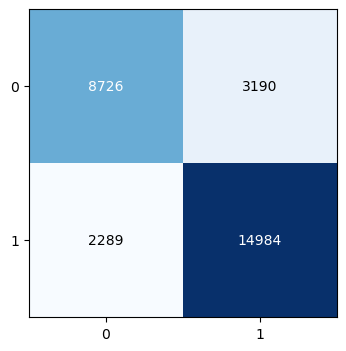

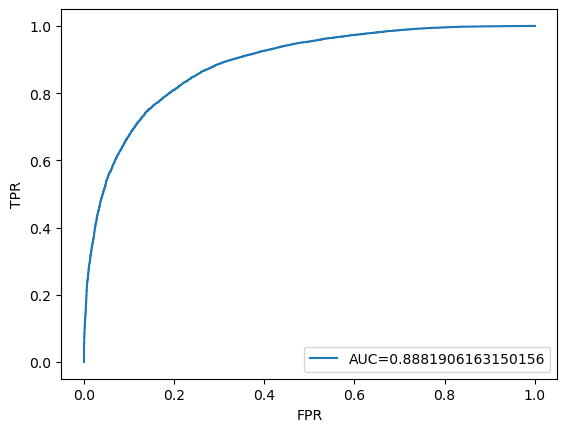

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
1,1.0,0.820634,0.003468
2,2.0,0.819958,0.004365
0,0.5,0.817734,0.004477


LR
accuracy 0.8257220185686389
f1_macro 0.8206342803210848


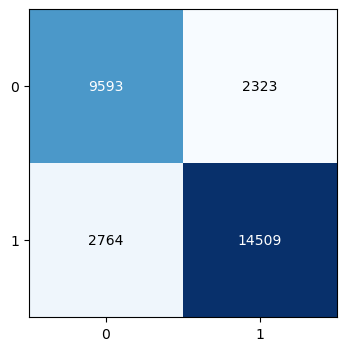

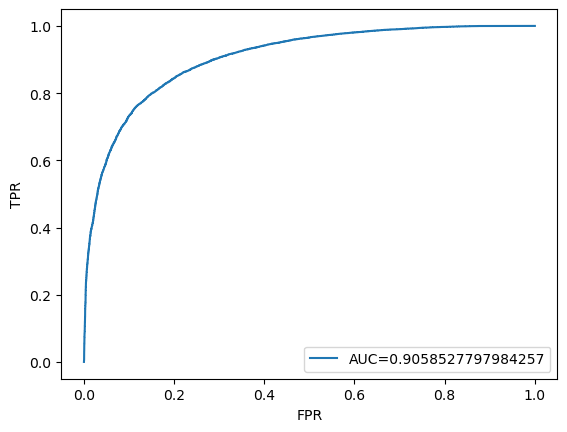

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.811521,0.004401
1,1.0,0.803347,0.003573
2,2.0,0.796046,0.002931


SVM
accuracy 0.8175340025352016
f1_macro 0.8115223070482455


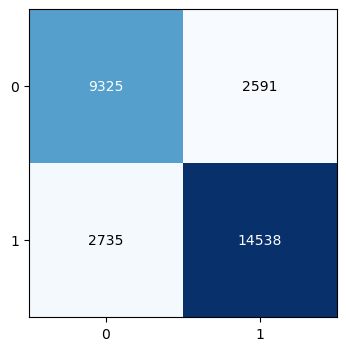

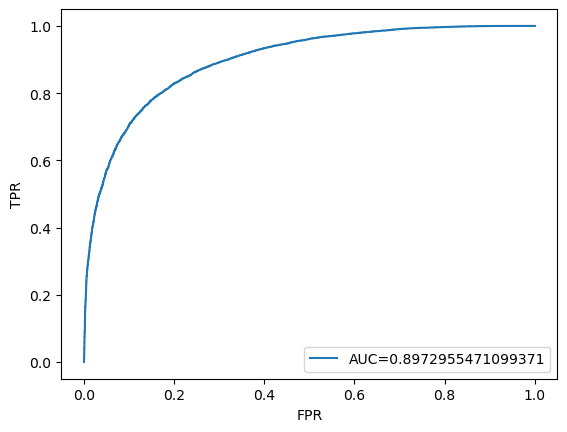

In [16]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import (accuracy_score,confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
HTML_PATTERN = re.compile(r"<.*?>")
ALLOWED_CHARS = re.compile(r"[^a-z0-9\.\!\?\'\s]")
CONTRACTIONS = {"can't":"cannot","won't":"will not","n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'ve":" have","'m":" am"}
NEG_CUES = {"not","never","no","n't","cannot"}
STOPWORDS = {"the","and","a","an","of","in","on","at","to","is","it","this","that","i","you","he","she","they","we","was","were","be","been","am","are","but","if","or","as","with","for","not","no","so","too","very"}

def expand_contractions(t):
    for p,r in CONTRACTIONS.items():
        t = re.sub(p,r,t)
    return t

def basic_clean(t):
    t = expand_contractions(t.lower())
    t = HTML_PATTERN.sub(" ",t)
    t = URL_PATTERN.sub(" ",t)
    t = ALLOWED_CHARS.sub(" ",t)
    return re.sub(r"\s+"," ",t).strip()

def clean_series(s):
    return s.astype(str).fillna("").map(basic_clean)

def mark_negations(s):
    out = []
    for txt in s:
        neg = False
        buf = []
        for tok in txt.split():
            if tok in NEG_CUES:
                buf.append(f"{tok}_NEG")
                neg = True
            elif neg and re.fullmatch(r"[a-z0-9']+",tok):
                buf.append(f"{tok}_NEG")
            else:
                buf.append(tok)
                if re.search(r"[\.\!\?]$",tok):
                    neg = False
        out.append(" ".join(buf))
    return pd.Series(out,index=s.index)

def remove_stopwords(s):
    return s.map(lambda t:" ".join(w for w in t.split() if len(w)>1 and w not in STOPWORDS))

def show_cv_table(res, cols):
    df = pd.DataFrame(res)
    param_cols = [f"param_{c}" for c in cols]
    tbl = df[param_cols + ["mean_test_score", "std_test_score"]]
    tbl = tbl.rename(columns=dict(zip(param_cols, cols)))
    display(tbl.sort_values("mean_test_score", ascending=False))


def evaluate_model(y_true,y_pred,y_prob,name):
    print(name)
    print("accuracy",accuracy_score(y_true,y_pred))
    print("f1_macro",f1_score(y_true,y_pred,average="macro"))
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(4,4)); plt.imshow(cm,cmap="Blues"); plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]),ha="center",va="center",color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.show()
    fpr,tpr,_ = roc_curve(y_true,y_prob)
    plt.figure(); plt.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def run_cv(build_fn,X,y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipes,grids = build_fn()
    best_models = {}
    scores = {}
    for name,pipe in pipes.items():
        gs = GridSearchCV(pipe,grids[name],cv=cv,scoring="f1_macro",n_jobs=-1,verbose=1)
        gs.fit(X,y)
        show_cv_table(gs.cv_results_,list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        if name == "SVM":
            scr = cross_val_predict(best_models[name],X,y,cv=cv,method="decision_function")
            preds = (scr >= 0).astype(int)
            probs = expit(scr)
        else:
            preds = cross_val_predict(best_models[name],X,y,cv=cv,method="predict")
            probs = cross_val_predict(best_models[name],X,y,cv=cv,method="predict_proba")[:,1]
        evaluate_model(y,preds,probs,name)
        scores[name] = f1_score(y,preds,average="macro")
    best_name = max(scores,key=scores.get)
    return best_models[best_name]

def load_data_fp():
    tr = pd.read_csv("train2.csv").drop_duplicates()
    te = pd.read_csv("test2.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("")+" "+tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("")+" "+te["summary"].fillna("")
    tr = tr[tr["combined"].str.len()>10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = (tr["overall"]>2).astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def build_pipelines_fp():
    cnt = CountVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,binary=True)
    tfd = TfidfVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,sublinear_tf=True)
    pipe_nb = Pipeline([("vect",cnt),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("vect",tfd),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=300))])
    pipe_svm = Pipeline([("vect",TfidfVectorizer(stop_words="english",lowercase=True,max_df=0.8,min_df=3,sublinear_tf=True,ngram_range=(1,2),max_features=10000)),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,1]},"LR":{"clf__C":[0.5,1]},"SVM":{"clf__C":[0.5,1]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_fp()
    best_model = run_cv(build_pipelines_fp,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("text2_output1.csv",index=False)

def load_data_mid():
    tr = pd.read_csv("train2.csv").drop_duplicates()
    te = pd.read_csv("test2.csv").drop_duplicates()
    for df in (tr,te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
        df["verified"] = df["verified"].fillna(False).astype(int)
        df["vote"] = pd.to_numeric(df["vote"].astype(str).str.replace(",",""),errors="coerce").fillna(0.0)
    y = (tr["overall"]>2).astype(int).values
    ids = te["id"].tolist()
    return tr.drop(columns=["overall"]), te, y, ids

def preprocessor_mid():
    tfidf_review = TfidfVectorizer(max_features=60000,ngram_range=(1,2),stop_words="english",min_df=3,sublinear_tf=True)
    tfidf_summary = TfidfVectorizer(max_features=15000,ngram_range=(1,1),stop_words="english",min_df=2,sublinear_tf=True)
    tfidf_category = TfidfVectorizer(analyzer="char",ngram_range=(3,5),min_df=1)
    return ColumnTransformer([
        ("review",tfidf_review,"reviewText"),
        ("summary",tfidf_summary,"summary"),
        ("category",tfidf_category,"category"),
        ("verified",OneHotEncoder(handle_unknown="ignore"),["verified"]),
        ("vote",FunctionTransformer(func=np.log1p,validate=False,feature_names_out="one-to-one"),["vote"])
    ],remainder="drop",sparse_threshold=0.3)

def build_pipelines_mid():
    feat = preprocessor_mid()
    pipe_nb = Pipeline([("feat",feat),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("feat",feat),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=2000))])
    pipe_svm = Pipeline([("feat",feat),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,0.5,1.0]},"LR":{"clf__C":[0.5,1.0,2.0]},"SVM":{"clf__C":[0.5,1.0,2.0]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_mid()
    best_model = run_cv(build_pipelines_mid,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("test2_output2.csv",index=False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.798649,0.006860
1,1.0,0.797878,0.006919


NB
accuracy 0.8041742348949587
f1_macro 0.7986456607021202


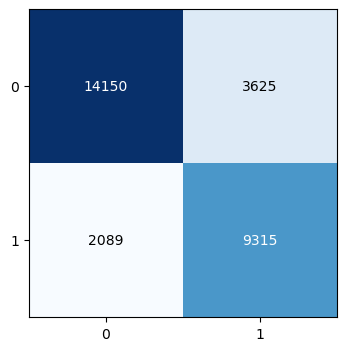

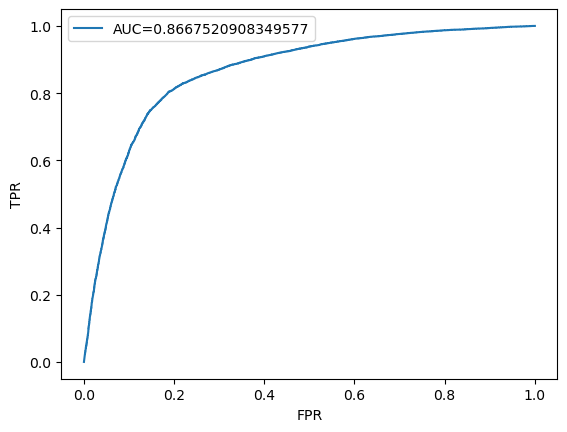

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
1,1.0,0.832293,0.007309
0,0.5,0.828204,0.007546


LR
accuracy 0.8384454573494636
f1_macro 0.8322925589536074


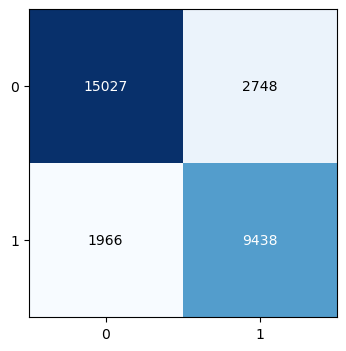

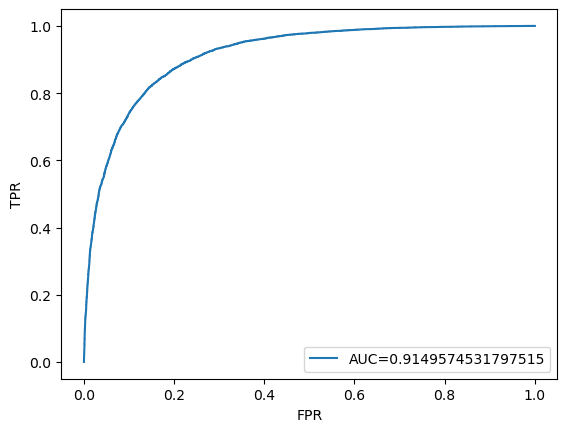

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.826250,0.006820
1,1.0,0.817895,0.007639


SVM
accuracy 0.8324479934199253
f1_macro 0.8262477602621083


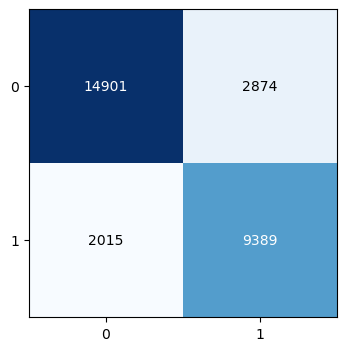

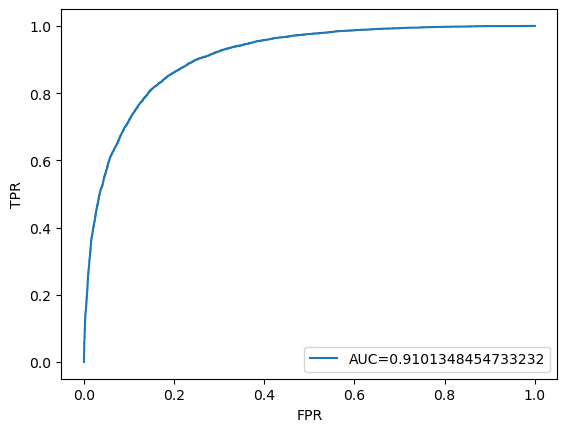

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
1,0.5,0.812827,0.003587
0,0.1,0.810969,0.001985
2,1.0,0.786331,0.003565


NB
accuracy 0.8253794237555243
f1_macro 0.812837495458653


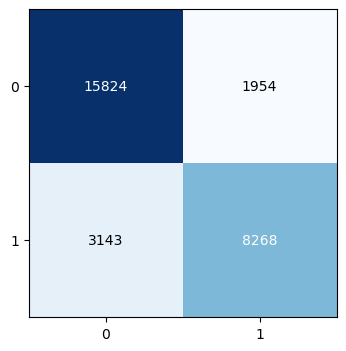

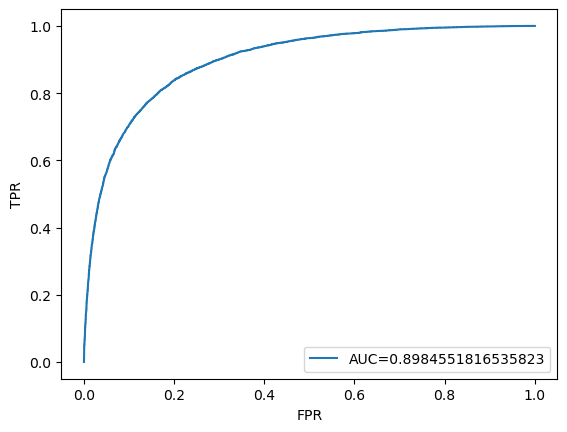

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
2,2.0,0.833804,0.003452
1,1.0,0.832425,0.003844
0,0.5,0.828008,0.003548


LR
accuracy 0.8399054438315804
f1_macro 0.8338056938688951


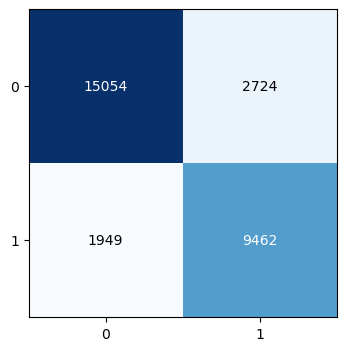

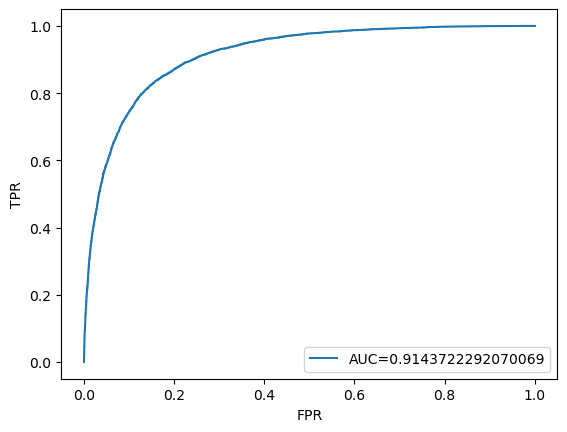

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.828444,0.003335
1,1.0,0.822012,0.003219
2,2.0,0.813848,0.003818


SVM
accuracy 0.8350063380040427
f1_macro 0.8284435448432195


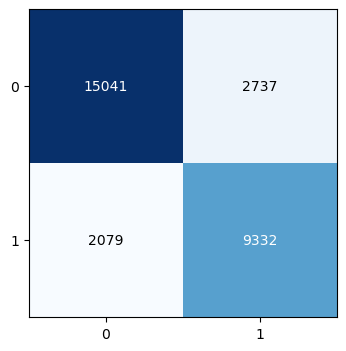

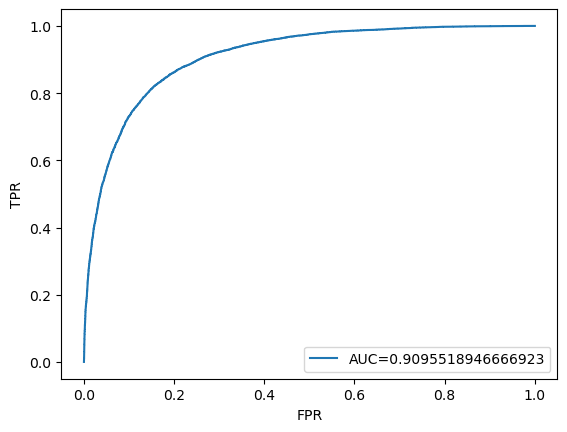

In [17]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import (accuracy_score,confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
HTML_PATTERN = re.compile(r"<.*?>")
ALLOWED_CHARS = re.compile(r"[^a-z0-9\.\!\?\'\s]")
CONTRACTIONS = {"can't":"cannot","won't":"will not","n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'ve":" have","'m":" am"}
NEG_CUES = {"not","never","no","n't","cannot"}
STOPWORDS = {"the","and","a","an","of","in","on","at","to","is","it","this","that","i","you","he","she","they","we","was","were","be","been","am","are","but","if","or","as","with","for","not","no","so","too","very"}

def expand_contractions(t):
    for p,r in CONTRACTIONS.items():
        t = re.sub(p,r,t)
    return t

def basic_clean(t):
    t = expand_contractions(t.lower())
    t = HTML_PATTERN.sub(" ",t)
    t = URL_PATTERN.sub(" ",t)
    t = ALLOWED_CHARS.sub(" ",t)
    return re.sub(r"\s+"," ",t).strip()

def clean_series(s):
    return s.astype(str).fillna("").map(basic_clean)

def mark_negations(s):
    out = []
    for txt in s:
        neg = False
        buf = []
        for tok in txt.split():
            if tok in NEG_CUES:
                buf.append(f"{tok}_NEG")
                neg = True
            elif neg and re.fullmatch(r"[a-z0-9']+",tok):
                buf.append(f"{tok}_NEG")
            else:
                buf.append(tok)
                if re.search(r"[\.\!\?]$",tok):
                    neg = False
        out.append(" ".join(buf))
    return pd.Series(out,index=s.index)

def remove_stopwords(s):
    return s.map(lambda t:" ".join(w for w in t.split() if len(w)>1 and w not in STOPWORDS))

def show_cv_table(res, cols):
    df = pd.DataFrame(res)
    param_cols = [f"param_{c}" for c in cols]
    tbl = df[param_cols + ["mean_test_score", "std_test_score"]]
    tbl = tbl.rename(columns=dict(zip(param_cols, cols)))
    display(tbl.sort_values("mean_test_score", ascending=False))


def evaluate_model(y_true,y_pred,y_prob,name):
    print(name)
    print("accuracy",accuracy_score(y_true,y_pred))
    print("f1_macro",f1_score(y_true,y_pred,average="macro"))
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(4,4)); plt.imshow(cm,cmap="Blues"); plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]),ha="center",va="center",color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.show()
    fpr,tpr,_ = roc_curve(y_true,y_prob)
    plt.figure(); plt.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def run_cv(build_fn,X,y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipes,grids = build_fn()
    best_models = {}
    scores = {}
    for name,pipe in pipes.items():
        gs = GridSearchCV(pipe,grids[name],cv=cv,scoring="f1_macro",n_jobs=-1,verbose=1)
        gs.fit(X,y)
        show_cv_table(gs.cv_results_,list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        if name == "SVM":
            scr = cross_val_predict(best_models[name],X,y,cv=cv,method="decision_function")
            preds = (scr >= 0).astype(int)
            probs = expit(scr)
        else:
            preds = cross_val_predict(best_models[name],X,y,cv=cv,method="predict")
            probs = cross_val_predict(best_models[name],X,y,cv=cv,method="predict_proba")[:,1]
        evaluate_model(y,preds,probs,name)
        scores[name] = f1_score(y,preds,average="macro")
    best_name = max(scores,key=scores.get)
    return best_models[best_name]

def load_data_fp():
    tr = pd.read_csv("train3.csv").drop_duplicates()
    te = pd.read_csv("test3.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("")+" "+tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("")+" "+te["summary"].fillna("")
    tr = tr[tr["combined"].str.len()>10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = (tr["overall"]>3).astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def build_pipelines_fp():
    cnt = CountVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,binary=True)
    tfd = TfidfVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,sublinear_tf=True)
    pipe_nb = Pipeline([("vect",cnt),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("vect",tfd),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=300))])
    pipe_svm = Pipeline([("vect",TfidfVectorizer(stop_words="english",lowercase=True,max_df=0.8,min_df=3,sublinear_tf=True,ngram_range=(1,2),max_features=10000)),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,1]},"LR":{"clf__C":[0.5,1]},"SVM":{"clf__C":[0.5,1]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_fp()
    best_model = run_cv(build_pipelines_fp,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("text3_output1.csv",index=False)

def load_data_mid():
    tr = pd.read_csv("train3.csv").drop_duplicates()
    te = pd.read_csv("test3.csv").drop_duplicates()
    for df in (tr,te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
        df["verified"] = df["verified"].fillna(False).astype(int)
        df["vote"] = pd.to_numeric(df["vote"].astype(str).str.replace(",",""),errors="coerce").fillna(0.0)
    y = (tr["overall"]>3).astype(int).values
    ids = te["id"].tolist()
    return tr.drop(columns=["overall"]), te, y, ids

def preprocessor_mid():
    tfidf_review = TfidfVectorizer(max_features=60000,ngram_range=(1,2),stop_words="english",min_df=3,sublinear_tf=True)
    tfidf_summary = TfidfVectorizer(max_features=15000,ngram_range=(1,1),stop_words="english",min_df=2,sublinear_tf=True)
    tfidf_category = TfidfVectorizer(analyzer="char",ngram_range=(3,5),min_df=1)
    return ColumnTransformer([
        ("review",tfidf_review,"reviewText"),
        ("summary",tfidf_summary,"summary"),
        ("category",tfidf_category,"category"),
        ("verified",OneHotEncoder(handle_unknown="ignore"),["verified"]),
        ("vote",FunctionTransformer(func=np.log1p,validate=False,feature_names_out="one-to-one"),["vote"])
    ],remainder="drop",sparse_threshold=0.3)

def build_pipelines_mid():
    feat = preprocessor_mid()
    pipe_nb = Pipeline([("feat",feat),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("feat",feat),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=2000))])
    pipe_svm = Pipeline([("feat",feat),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,0.5,1.0]},"LR":{"clf__C":[0.5,1.0,2.0]},"SVM":{"clf__C":[0.5,1.0,2.0]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_mid()
    best_model = run_cv(build_pipelines_mid,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("test3_output3.csv",index=False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.743233,0.005971
1,1.0,0.741480,0.005593


NB
accuracy 0.8155522807498543
f1_macro 0.743240714152356


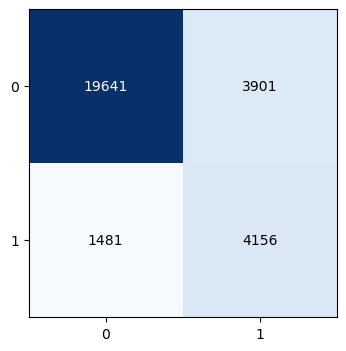

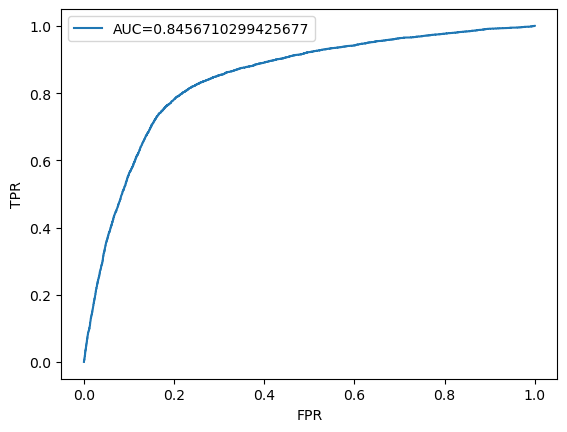

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
1,1.0,0.764553,0.004341
0,0.5,0.762066,0.003137


LR
accuracy 0.8305630761849275
f1_macro 0.7645650658700905


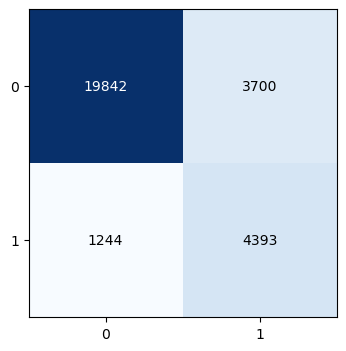

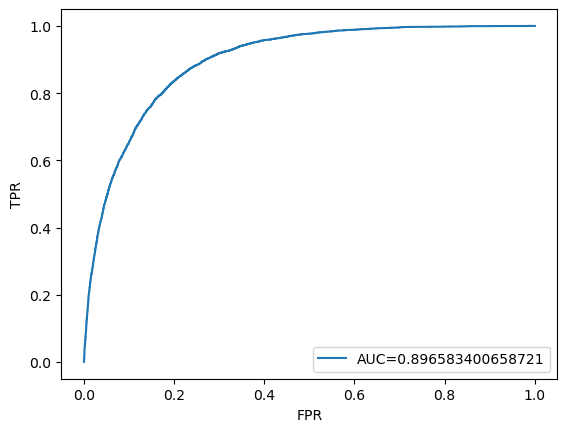

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.756645,0.001525
1,1.0,0.749002,0.004403


SVM
accuracy 0.8273415812742041
f1_macro 0.7566466458584071


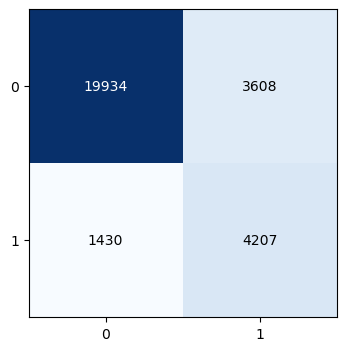

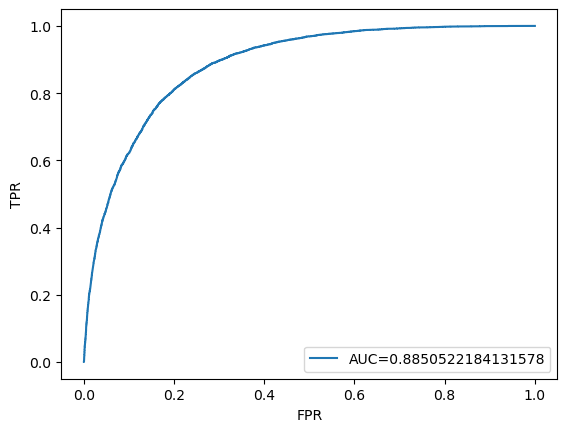

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.738987,0.008360
1,0.5,0.576985,0.010050
2,1.0,0.465434,0.004684


NB
accuracy 0.8487443900099353
f1_macro 0.7390272839797074


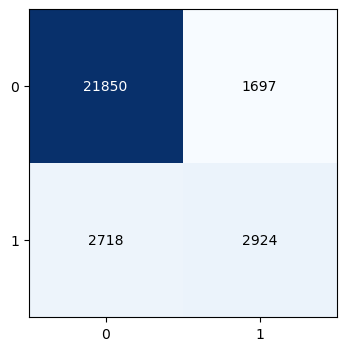

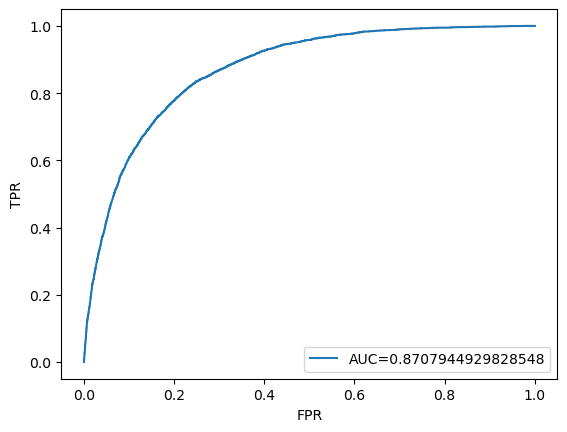

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
2,2.0,0.766561,0.006425
1,1.0,0.763051,0.005502
0,0.5,0.757957,0.004021


LR
accuracy 0.8389119188735482
f1_macro 0.7665744677275821


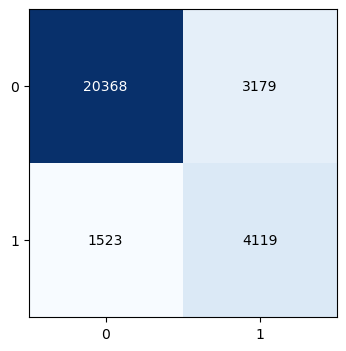

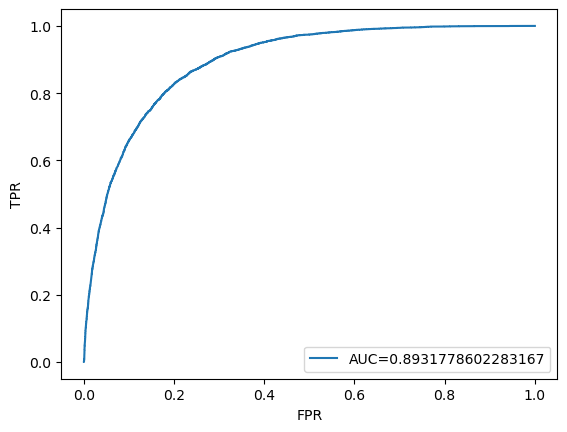

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.762191,0.005319
1,1.0,0.756843,0.005158
2,2.0,0.746717,0.004921


SVM
accuracy 0.8399739627942033
f1_macro 0.7622117235601072


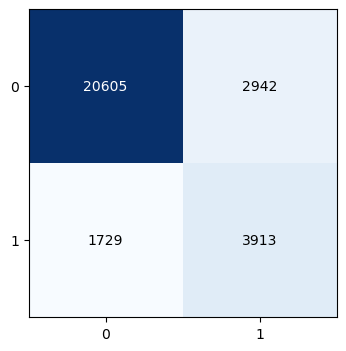

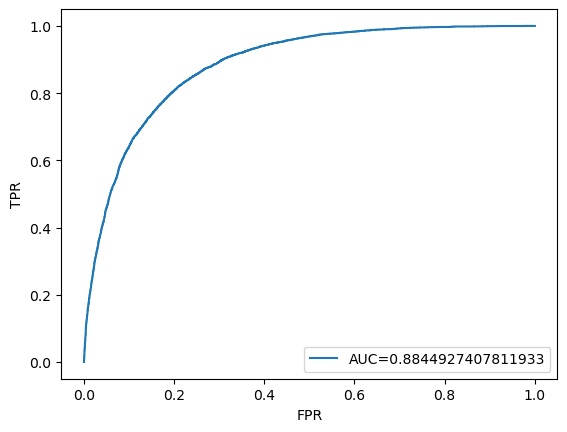

In [18]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import (accuracy_score,confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
HTML_PATTERN = re.compile(r"<.*?>")
ALLOWED_CHARS = re.compile(r"[^a-z0-9\.\!\?\'\s]")
CONTRACTIONS = {"can't":"cannot","won't":"will not","n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'ve":" have","'m":" am"}
NEG_CUES = {"not","never","no","n't","cannot"}
STOPWORDS = {"the","and","a","an","of","in","on","at","to","is","it","this","that","i","you","he","she","they","we","was","were","be","been","am","are","but","if","or","as","with","for","not","no","so","too","very"}

def expand_contractions(t):
    for p,r in CONTRACTIONS.items():
        t = re.sub(p,r,t)
    return t

def basic_clean(t):
    t = expand_contractions(t.lower())
    t = HTML_PATTERN.sub(" ",t)
    t = URL_PATTERN.sub(" ",t)
    t = ALLOWED_CHARS.sub(" ",t)
    return re.sub(r"\s+"," ",t).strip()

def clean_series(s):
    return s.astype(str).fillna("").map(basic_clean)

def mark_negations(s):
    out = []
    for txt in s:
        neg = False
        buf = []
        for tok in txt.split():
            if tok in NEG_CUES:
                buf.append(f"{tok}_NEG")
                neg = True
            elif neg and re.fullmatch(r"[a-z0-9']+",tok):
                buf.append(f"{tok}_NEG")
            else:
                buf.append(tok)
                if re.search(r"[\.\!\?]$",tok):
                    neg = False
        out.append(" ".join(buf))
    return pd.Series(out,index=s.index)

def remove_stopwords(s):
    return s.map(lambda t:" ".join(w for w in t.split() if len(w)>1 and w not in STOPWORDS))

def show_cv_table(res, cols):
    df = pd.DataFrame(res)
    param_cols = [f"param_{c}" for c in cols]
    tbl = df[param_cols + ["mean_test_score", "std_test_score"]]
    tbl = tbl.rename(columns=dict(zip(param_cols, cols)))
    display(tbl.sort_values("mean_test_score", ascending=False))


def evaluate_model(y_true,y_pred,y_prob,name):
    print(name)
    print("accuracy",accuracy_score(y_true,y_pred))
    print("f1_macro",f1_score(y_true,y_pred,average="macro"))
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(4,4)); plt.imshow(cm,cmap="Blues"); plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]),ha="center",va="center",color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.show()
    fpr,tpr,_ = roc_curve(y_true,y_prob)
    plt.figure(); plt.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def run_cv(build_fn,X,y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipes,grids = build_fn()
    best_models = {}
    scores = {}
    for name,pipe in pipes.items():
        gs = GridSearchCV(pipe,grids[name],cv=cv,scoring="f1_macro",n_jobs=-1,verbose=1)
        gs.fit(X,y)
        show_cv_table(gs.cv_results_,list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        if name == "SVM":
            scr = cross_val_predict(best_models[name],X,y,cv=cv,method="decision_function")
            preds = (scr >= 0).astype(int)
            probs = expit(scr)
        else:
            preds = cross_val_predict(best_models[name],X,y,cv=cv,method="predict")
            probs = cross_val_predict(best_models[name],X,y,cv=cv,method="predict_proba")[:,1]
        evaluate_model(y,preds,probs,name)
        scores[name] = f1_score(y,preds,average="macro")
    best_name = max(scores,key=scores.get)
    return best_models[best_name]

def load_data_fp():
    tr = pd.read_csv("train4.csv").drop_duplicates()
    te = pd.read_csv("test4.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("")+" "+tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("")+" "+te["summary"].fillna("")
    tr = tr[tr["combined"].str.len()>10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = (tr["overall"]>4).astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def build_pipelines_fp():
    cnt = CountVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,binary=True)
    tfd = TfidfVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,sublinear_tf=True)
    pipe_nb = Pipeline([("vect",cnt),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("vect",tfd),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=300))])
    pipe_svm = Pipeline([("vect",TfidfVectorizer(stop_words="english",lowercase=True,max_df=0.8,min_df=3,sublinear_tf=True,ngram_range=(1,2),max_features=10000)),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,1]},"LR":{"clf__C":[0.5,1]},"SVM":{"clf__C":[0.5,1]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_fp()
    best_model = run_cv(build_pipelines_fp,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("text4_output1.csv",index=False)

def load_data_mid():
    tr = pd.read_csv("train4.csv").drop_duplicates()
    te = pd.read_csv("test4.csv").drop_duplicates()
    for df in (tr,te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
        df["verified"] = df["verified"].fillna(False).astype(int)
        df["vote"] = pd.to_numeric(df["vote"].astype(str).str.replace(",",""),errors="coerce").fillna(0.0)
    y = (tr["overall"]>4).astype(int).values
    ids = te["id"].tolist()
    return tr.drop(columns=["overall"]), te, y, ids

def preprocessor_mid():
    tfidf_review = TfidfVectorizer(max_features=60000,ngram_range=(1,2),stop_words="english",min_df=3,sublinear_tf=True)
    tfidf_summary = TfidfVectorizer(max_features=15000,ngram_range=(1,1),stop_words="english",min_df=2,sublinear_tf=True)
    tfidf_category = TfidfVectorizer(analyzer="char",ngram_range=(3,5),min_df=1)
    return ColumnTransformer([
        ("review",tfidf_review,"reviewText"),
        ("summary",tfidf_summary,"summary"),
        ("category",tfidf_category,"category"),
        ("verified",OneHotEncoder(handle_unknown="ignore"),["verified"]),
        ("vote",FunctionTransformer(func=np.log1p,validate=False,feature_names_out="one-to-one"),["vote"])
    ],remainder="drop",sparse_threshold=0.3)

def build_pipelines_mid():
    feat = preprocessor_mid()
    pipe_nb = Pipeline([("feat",feat),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("feat",feat),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=2000))])
    pipe_svm = Pipeline([("feat",feat),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,0.5,1.0]},"LR":{"clf__C":[0.5,1.0,2.0]},"SVM":{"clf__C":[0.5,1.0,2.0]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_mid()
    best_model = run_cv(build_pipelines_mid,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("test4_output4.csv",index=False)

In [19]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import (accuracy_score,confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
HTML_PATTERN = re.compile(r"<.*?>")
ALLOWED_CHARS = re.compile(r"[^a-z0-9\.\!\?\'\s]")
CONTRACTIONS = {"can't":"cannot","won't":"will not","n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'ve":" have","'m":" am"}
NEG_CUES = {"not","never","no","n't","cannot"}
STOPWORDS = {"the","and","a","an","of","in","on","at","to","is","it","this","that","i","you","he","she","they","we","was","were","be","been","am","are","but","if","or","as","with","for","not","no","so","too","very"}

def expand_contractions(t):
    for p,r in CONTRACTIONS.items():
        t = re.sub(p,r,t)
    return t

def basic_clean(t):
    t = expand_contractions(t.lower())
    t = HTML_PATTERN.sub(" ",t)
    t = URL_PATTERN.sub(" ",t)
    t = ALLOWED_CHARS.sub(" ",t)
    return re.sub(r"\s+"," ",t).strip()

def clean_series(s):
    return s.astype(str).fillna("").map(basic_clean)

def mark_negations(s):
    out = []
    for txt in s:
        neg = False
        buf = []
        for tok in txt.split():
            if tok in NEG_CUES:
                buf.append(f"{tok}_NEG")
                neg = True
            elif neg and re.fullmatch(r"[a-z0-9']+",tok):
                buf.append(f"{tok}_NEG")
            else:
                buf.append(tok)
                if re.search(r"[\.\!\?]$",tok):
                    neg = False
        out.append(" ".join(buf))
    return pd.Series(out,index=s.index)

def remove_stopwords(s):
    return s.map(lambda t:" ".join(w for w in t.split() if len(w)>1 and w not in STOPWORDS))

def show_cv_table(res, cols):
    df = pd.DataFrame(res)
    param_cols = [f"param_{c}" for c in cols]
    tbl = df[param_cols + ["mean_test_score", "std_test_score"]]
    tbl = tbl.rename(columns=dict(zip(param_cols, cols)))
    display(tbl.sort_values("mean_test_score", ascending=False))


def evaluate_model(y_true,y_pred,y_prob,name):
    print(name)
    print("accuracy",accuracy_score(y_true,y_pred))
    print("f1_macro",f1_score(y_true,y_pred,average="macro"))
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(4,4)); plt.imshow(cm,cmap="Blues"); plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]),ha="center",va="center",color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.show()
    fpr,tpr,_ = roc_curve(y_true,y_prob)
    plt.figure(); plt.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def run_cv(build_fn,X,y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipes,grids = build_fn()
    best_models = {}
    scores = {}
    for name,pipe in pipes.items():
        gs = GridSearchCV(pipe,grids[name],cv=cv,scoring="f1_macro",n_jobs=-1,verbose=1)
        gs.fit(X,y)
        show_cv_table(gs.cv_results_,list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        if name == "SVM":
            scr = cross_val_predict(best_models[name],X,y,cv=cv,method="decision_function")
            preds = (scr >= 0).astype(int)
            probs = expit(scr)
        else:
            preds = cross_val_predict(best_models[name],X,y,cv=cv,method="predict")
            probs = cross_val_predict(best_models[name],X,y,cv=cv,method="predict_proba")[:,1]
        evaluate_model(y,preds,probs,name)
        scores[name] = f1_score(y,preds,average="macro")
    best_name = max(scores,key=scores.get)
    return best_models[best_name]

def load_data_fp():
    tr = pd.read_csv("train5.csv").drop_duplicates()
    te = pd.read_csv("test5.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("")+" "+tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("")+" "+te["summary"].fillna("")
    tr = tr[tr["combined"].str.len()>10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = (tr["overall"]>5).astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def build_pipelines_fp():
    cnt = CountVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,binary=True)
    tfd = TfidfVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,sublinear_tf=True)
    pipe_nb = Pipeline([("vect",cnt),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("vect",tfd),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=300))])
    pipe_svm = Pipeline([("vect",TfidfVectorizer(stop_words="english",lowercase=True,max_df=0.8,min_df=3,sublinear_tf=True,ngram_range=(1,2),max_features=10000)),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,1]},"LR":{"clf__C":[0.5,1]},"SVM":{"clf__C":[0.5,1]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_fp()
    best_model = run_cv(build_pipelines_fp,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("text5_output1.csv",index=False)

def load_data_mid():
    tr = pd.read_csv("train5.csv").drop_duplicates()
    te = pd.read_csv("test5.csv").drop_duplicates()
    for df in (tr,te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
        df["verified"] = df["verified"].fillna(False).astype(int)
        df["vote"] = pd.to_numeric(df["vote"].astype(str).str.replace(",",""),errors="coerce").fillna(0.0)
    y = (tr["overall"]>5).astype(int).values
    ids = te["id"].tolist()
    return tr.drop(columns=["overall"]), te, y, ids

def preprocessor_mid():
    tfidf_review = TfidfVectorizer(max_features=60000,ngram_range=(1,2),stop_words="english",min_df=3,sublinear_tf=True)
    tfidf_summary = TfidfVectorizer(max_features=15000,ngram_range=(1,1),stop_words="english",min_df=2,sublinear_tf=True)
    tfidf_category = TfidfVectorizer(analyzer="char",ngram_range=(3,5),min_df=1)
    return ColumnTransformer([
        ("review",tfidf_review,"reviewText"),
        ("summary",tfidf_summary,"summary"),
        ("category",tfidf_category,"category"),
        ("verified",OneHotEncoder(handle_unknown="ignore"),["verified"]),
        ("vote",FunctionTransformer(func=np.log1p,validate=False,feature_names_out="one-to-one"),["vote"])
    ],remainder="drop",sparse_threshold=0.3)

def build_pipelines_mid():
    feat = preprocessor_mid()
    pipe_nb = Pipeline([("feat",feat),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("feat",feat),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=2000))])
    pipe_svm = Pipeline([("feat",feat),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,0.5,1.0]},"LR":{"clf__C":[0.5,1.0,2.0]},"SVM":{"clf__C":[0.5,1.0,2.0]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_mid()
    best_model = run_cv(build_pipelines_mid,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("test5_output4.csv",index=False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,1.0,0.0
1,1.0,1.0,0.0


IndexError: index 1 is out of bounds for axis 1 with size 1